# Extracting Data

In [ ]:
!unzip drive/MyDrive/plant-seedlings-classification\ \(1\).zip

Streaming output truncated to the last 5000 lines.
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      

# Important Libraries

In [ ]:
!pip install keras-tuner

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import pathlib
import os
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from kerastuner.tuners import Hyperband
from keras.models import load_model


# Visulasing our Data

In [ ]:
#loading Sample Submission to see how we need to submit it
sample_submission=pd.read_csv('sample_submission.csv')
sample_submission

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet
...,...,...
789,fea355851.png,Sugar beet
790,fea3da57c.png,Sugar beet
791,fef2ade8c.png,Sugar beet
792,ff65bc002.png,Sugar beet


No charts were generated by quickchart


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_1, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_2, *['index', 'count()', None], **{})
chart

In [ ]:
#creating function which create a path for different species
def path_difine(file_path):
  directory_path = os.path.abspath(file_path)
  path_dir = pathlib.Path(directory_path)
  png_files = list(path_dir.glob('*.png'))
  return png_files

In [ ]:
#creating train dictionary for load whole data class wise
train={
    'black_grass':path_difine('/content/train/Black-grass'),
    'charlock':path_difine('/content/train/Charlock'),
    'cleavers':path_difine('/content/train/Cleavers'),
    'common_chickweed':path_difine('/content/train/Common Chickweed'),
    'common_wheat':path_difine('/content/train/Common wheat'),
    'fat_hen':path_difine('/content/train/Fat Hen'),
    'loose_silky_bent':path_difine('/content/train/Loose Silky-bent'),
    'maize':path_difine('/content/train/Maize'),
    'scentless_mayweed':path_difine('/content/train/Scentless Mayweed'),
    'shepherds_purse':path_difine('/content/train/Shepherds Purse'),
    'small_flowered_cranesbill':path_difine('/content/train/Small-flowered Cranesbill'),
    'sugar_beet':path_difine('/content/train/Sugar beet'),

}

In [ ]:
#creating another dictionary for giving numbers to classes
train_labels={
    'black_grass':0,
    'charlock':1,
    'cleavers':2,
    'common_chickweed':3,
    'common_wheat':4,
    'fat_hen':5,
    'loose_silky_bent':6,
    'maize':7,
    'scentless_mayweed':8,
    'shepherds_purse':9,
    'small_flowered_cranesbill':10,
    'sugar_beet':11,

}

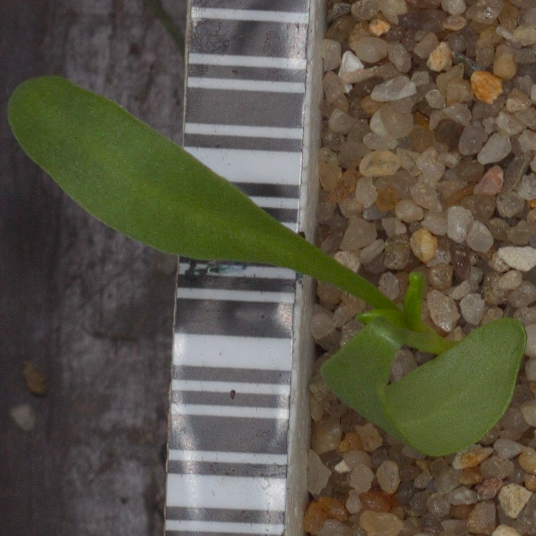

In [ ]:
Image.open(train['sugar_beet'][60])

2

# Data Cleaning
1. loading data and converting in form numpy array,image dimenson is 180x180.
2. Creating train and validation sample
3. dividing x_train and x_val by 255
4. One hot encoding in y_train and y_val
5. Creating data augmentation for increasing size of data

In [ ]:
# creating x and y two empty list
x=[]
y=[]
# extracing data from train dictionary in from of labels and images
for labels, images in train.items():
  for image in images:
    # converting images into array
    img=cv2.imread(str(image))
    # resizing images into 180x180
    resized_img=cv2.resize(img,(180,180))
    # appending images into x and labels into y
    x.append(resized_img)
    y.append(train_labels[labels])

In [ ]:
# converting data into numpy array
x=np.array(x)
y=np.array(y)

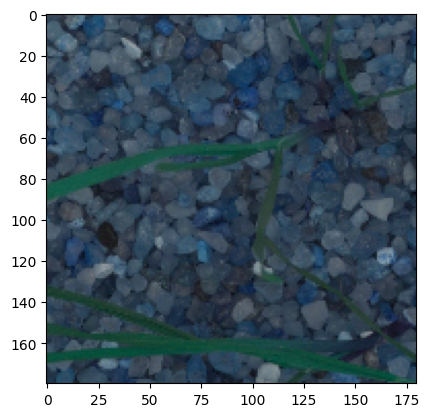

In [ ]:
plt.imshow(x[80])

In [ ]:
x[0].shape

(224, 224, 3)

In [ ]:
# spliting data into train and validation sample
x_train, x_val, y_train, y_val=train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
# rescaling image
x_train_s=x_train/255
x_val_s=x_val/255

In [ ]:
# doing one hot encoding
num_classes = 12
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes)

In [ ]:
x_train_s[0]

array([[[0.14117647, 0.3254902 , 0.55686275],
        [0.14509804, 0.33333333, 0.57647059],
        [0.18431373, 0.34509804, 0.58431373],
        ...,
        [0.23921569, 0.29019608, 0.37647059],
        [0.23921569, 0.30196078, 0.38823529],
        [0.23921569, 0.30980392, 0.38823529]],

       [[0.15294118, 0.31372549, 0.5254902 ],
        [0.16470588, 0.3254902 , 0.55686275],
        [0.16470588, 0.32156863, 0.55686275],
        ...,
        [0.24313725, 0.30588235, 0.40392157],
        [0.24313725, 0.31372549, 0.41176471],
        [0.25098039, 0.32941176, 0.41176471]],

       [[0.14901961, 0.29019608, 0.49803922],
        [0.14509804, 0.29019608, 0.50980392],
        [0.14509804, 0.29411765, 0.51372549],
        ...,
        [0.25490196, 0.32156863, 0.42352941],
        [0.2627451 , 0.3372549 , 0.43921569],
        [0.25882353, 0.3372549 , 0.42745098]],

       ...,

       [[0.10588235, 0.17647059, 0.2745098 ],
        [0.16078431, 0.22745098, 0.3254902 ],
        [0.23137255, 0

In [ ]:
y_train_one_hot.shape

(3800, 12)

In [ ]:
# creating data augmentation layer
input_shape = (180, 180, 3)
num_classes = 12
data_augmentation = tf.keras.Sequential([
    RandomFlip(mode='horizontal_and_vertical', input_shape=input_shape),
    RandomRotation(factor=0.2),
    RandomZoom(height_factor=0.2, width_factor=0.2),
    RandomTranslation(height_factor=0.1, width_factor=0.1)
    ])

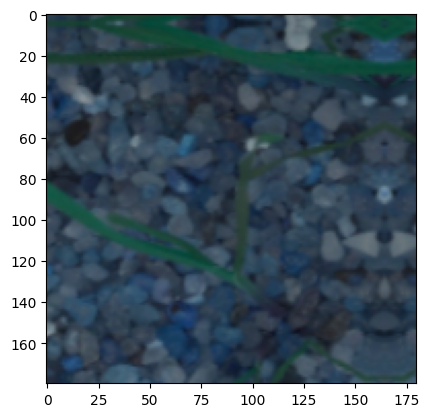

In [ ]:
plt.imshow(data_augmentation(x)[80].numpy().astype('uint8'))

# Model Bilding and Hyperparameter tuning
1. creating function which build model
2. Inside function creating model by giving different parameters for Hyperparameter tuning and compile with different learning rate
3. Then use use Hyperband tuner for hyperparameter tuning
4. Then search best model by Hyperparameter tuning
5. Take best model and train it on training data

In [ ]:
# function for build model
def build_model(hp):
    model = tf.keras.Sequential([
        RandomFlip(mode='horizontal_and_vertical', input_shape=(180, 180, 3)),
        RandomRotation(factor=0.2),
        RandomZoom(height_factor=0.2, width_factor=0.2),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            padding='same', activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            padding='same', activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
            padding='same', activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=392, step=120),
            activation='relu'
        ),
        tf.keras.layers.Dense(12, activation='sigmoid')
    ])

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
        metrics=['accuracy']
    )

    return model

# Instantiate the tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_results',
    project_name='seed_data_tuning'
)

# Performing hyperparameter tuning
tuner.search(
    x_train_s, y_train_one_hot,
    epochs=10, batch_size=32,
    validation_data=(x_val_s, y_val_one_hot)
)

# The best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hyperparameters)

Trial 30 Complete [00h 02m 43s]
val_accuracy: 0.14315789937973022

Best val_accuracy So Far: 0.8010526299476624
Total elapsed time: 00h 37m 18s
Best Hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7e226c7d0b20>


In [ ]:
# Building and compiling the best model
best_model = tuner.hypermodel.build(best_hyperparameters)
best_model.save('drive/MyDrive/Kaggle/best_model1.h5')
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters.get('learning_rate')),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# temporarily saving model
best_model.save('drive/MyDrive/Kaggle/best_model1.h5')

In [ ]:
# getting learning rate
learning_rate=best_hyperparameters.get('learning_rate')
learning_rate

0.001

In [ ]:
# loading and compiling model again
best_model=load_model('drive/MyDrive/Kaggle/best_model1.h5')
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Training the best model
best_model.fit(x_train_s, y_train_one_hot,
    epochs=33, batch_size=32,
    validation_data=(x_test_s, y_test_one_hot))

Epoch 1/33
119/119 [==============================] - 28s 102ms/step - loss: 2.4482 - accuracy: 0.1497 - val_loss: 2.1276 - val_accuracy: 0.2674
Epoch 2/33
119/119 [==============================] - 9s 80ms/step - loss: 1.8411 - accuracy: 0.3555 - val_loss: 1.5681 - val_accuracy: 0.4758
Epoch 3/33
119/119 [==============================] - 9s 75ms/step - loss: 1.5658 - accuracy: 0.4495 - val_loss: 1.4959 - val_accuracy: 0.4926
Epoch 4/33
119/119 [==============================] - 9s 80ms/step - loss: 1.2932 - accuracy: 0.5479 - val_loss: 1.0961 - val_accuracy: 0.6326
Epoch 5/33
119/119 [==============================] - 9s 73ms/step - loss: 1.1266 - accuracy: 0.6076 - val_loss: 0.9229 - val_accuracy: 0.6989
Epoch 6/33
119/119 [==============================] - 9s 75ms/step - loss: 1.0143 - accuracy: 0.6463 - val_loss: 0.8253 - val_accuracy: 0.7368
Epoch 7/33
119/119 [==============================] - 10s 80ms/step - loss: 0.9752 - accuracy: 0.6695 - val_loss: 0.9328 - val_accuracy: 0.6

In [ ]:
# saving again Best Modle
best_model.save('drive/MyDrive/Kaggle/best_model_for_seed_dataset.h5')

# Now Making Prediction in Test data Set
1. Extracting data from test folder
2. Converting and resizing images
3. Scaling images
4. Creating Data Frame of result and saving it




In [ ]:
# Extracting path of test data set
test=path_difine('test')

In [ ]:
test[0]

PosixPath('/content/test/d2f422ccb.png')

In [ ]:
# converting and resizing images
test_x=[]
for i in test:
  test_img=cv2.imread(str(i))
  test_re=cv2.resize(test_img,(180,180))
  test_x.append(test_re)

In [ ]:
# converting into numpy array
test_x=np.array(test_x)

In [ ]:
test_x.shape

(794, 180, 180, 3)

In [ ]:
# scaling images
test_x=test_x/255

In [ ]:
# prediction in test data set
test_pre=best_model.predict(test_x)

25/25 [==============================] - 1s 53ms/step


In [ ]:
test_pre

array([[6.8907470e-06, 6.8772149e-10, 2.9502908e-07, ..., 3.0039580e-04,
        3.3322218e-07, 1.5426822e-05],
       [3.9190832e-01, 2.5183237e-08, 2.9644975e-04, ..., 2.1889373e-07,
        1.9798159e-05, 3.8447401e-05],
       [2.2119648e-10, 1.4062172e-04, 6.8586825e-09, ..., 9.9980360e-01,
        1.5416268e-06, 2.9638764e-08],
       ...,
       [6.2190156e-07, 1.2368450e-04, 3.0462982e-04, ..., 9.1283822e-01,
        6.5335689e-06, 1.9687248e-05],
       [2.2193864e-04, 3.4952922e-08, 1.0661516e-04, ..., 3.5891521e-03,
        3.5011008e-06, 4.0818268e-04],
       [9.4774942e-04, 1.2937969e-07, 5.3497738e-06, ..., 1.3831240e-02,
        1.0455095e-01, 2.9679153e-03]], dtype=float32)

In [ ]:
# creating dictionary for labels it is a invers of train_labels dictionary
train_labels_invers={
    0:'Black-grass',
    1:'Charlock',
    2:'cleavers',
    3:'Common Chickweed',
    4:'Common wheat',
    5:'Fat Hen',
    6:'Loose Silky-bent',
    7:'Maize',
    8:'Scentless Mayweed',
    9:'Shepherds Purse',
    10:'Small-flowered Cranesbill',
    11:'Sugar beet',
}

In [ ]:
# Creating list for labels
labels=[]
for i in range(len(test_x)):
  labels.append(train_labels_invers[test_pre[i].argmax()])


In [ ]:
labels

['Common Chickweed',
 'Loose Silky-bent',
 'Shepherds Purse',
 'Sugar beet',
 'Scentless Mayweed',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Common Chickweed',
 'Loose Silky-bent',
 'cleavers',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Small-flowered Cranesbill',
 'Maize',
 'Fat Hen',
 'Common Chickweed',
 'Maize',
 'Shepherds Purse',
 'Fat Hen',
 'Loose Silky-bent',
 'Common wheat',
 'Charlock',
 'Charlock',
 'Common Chickweed',
 'Common Chickweed',
 'Sugar beet',
 'Loose Silky-bent',
 'Common Chickweed',
 'Sugar beet',
 'Fat Hen',
 'Maize',
 'Scentless Mayweed',
 'cleavers',
 'cleavers',
 'Maize',
 'Fat Hen',
 'Scentless Mayweed',
 'cleavers',
 'Small-flowered Cranesbill',
 'Scentless Mayweed',
 'Loose Silky-bent',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Common wheat',
 'Common Chickweed',
 'Common Chickweed',
 'Loose Silky-bent',
 'Charlock',
 'Fat Hen',
 'Sugar beet',
 'Fat

In [ ]:
# Extracting image id
fil=[str(x).split('/')[3] for x in test]
fil

['d2f422ccb.png',
 '7696badea.png',
 '42e7ed442.png',
 'ef02b4ee7.png',
 '1bf9b94a6.png',
 '599691cd9.png',
 'c88ebfb47.png',
 '593896f83.png',
 'e721c6ac8.png',
 '56a01b835.png',
 'a0f37c726.png',
 'b944a49ca.png',
 'a85fc8c9a.png',
 'afa446484.png',
 '6b9d6f8c9.png',
 '67e185673.png',
 '5bc6595f6.png',
 '1d321253f.png',
 'd8f4923f8.png',
 '377283a21.png',
 '3fbd0fc6a.png',
 '20f983a71.png',
 '1d0cbd819.png',
 '48ef6a2ff.png',
 '958bb9e96.png',
 '8cf909eb3.png',
 '4b032563b.png',
 'ae90f2827.png',
 '9baf94467.png',
 '592473c83.png',
 '29bab7cad.png',
 '6680836dd.png',
 '800a8c17e.png',
 '55fed435f.png',
 '64fe8beb9.png',
 'fa9f3a8f9.png',
 '22e79540f.png',
 'e4a76885b.png',
 'd3331e071.png',
 '205df1df3.png',
 '6ba4ef411.png',
 '8e3ed0a25.png',
 '98da6ef4e.png',
 '8303b27ed.png',
 'ec08a5d56.png',
 'e5881dd33.png',
 'ffc6f8527.png',
 'aa7d098d1.png',
 '00ef713a8.png',
 '686dc7ec8.png',
 '3eebd36c6.png',
 '3da774107.png',
 '071cb3ece.png',
 '5779fe8b4.png',
 'bea23d9f8.png',
 '14bb43ee

In [ ]:
# Creating result Data Frame
result1=pd.DataFrame({'file':fil,'species':labels})
result1

,file,species
0,d2f422ccb.png,Common Chickweed
1,7696badea.png,Loose Silky-bent
2,42e7ed442.png,Shepherds Purse
3,ef02b4ee7.png,Sugar beet
4,1bf9b94a6.png,Scentless Mayweed
...,...,...
789,0911d3dee.png,Common Chickweed
790,adb7a032c.png,Loose Silky-bent
791,da231c97f.png,Shepherds Purse
792,a74d475c2.png,Common Chickweed


In [ ]:
# Saving result Data set
result1.to_csv('drive/MyDrive/result1.csv',index=False)